<a href="https://colab.research.google.com/github/Arbarbn/Time-Series-Analysis-Forecasting-Projects-using-Python/blob/main/Energy_Consumption_Estimation_using_XGBOOST_and_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJM West Region Estimation Energy Consumption in MegaWatts

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.



**Ideas of what you could do with this dataset**:


1.  Split the last year into a test set- can you build a model to predict energy consumption?
2.  Find trends in energy consumption around hours of the day, holidays, or long term trends?
1.  Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.







In [ ]:
# Data preprocessing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Modelling : Prophet, XGBoost, ARIMA, LSTM
from fbprophet import Prophet
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

plt.style.use('fivethirtyeight')
palette = ["#F8766D", "#D39200", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
pjmw = pd.read_csv('/content/drive/MyDrive/Data Scientist/XGBoost/PJMW_hourly.csv.zip (Unzipped Files)/PJMW_hourly.csv', parse_dates=True, low_memory=False, index_col='Datetime')
pjmw.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


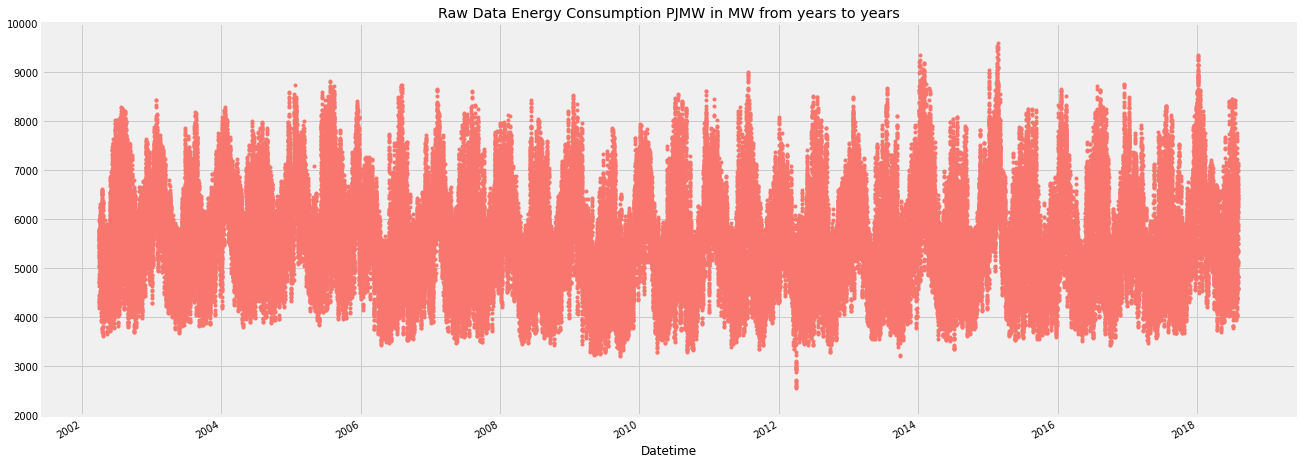

In [ ]:
pjmw.plot(figsize=(20,8), style='.', title = 'Raw Data Energy Consumption PJMW in MW from years to years', color=palette[0], grid=True, legend=False)
plt.ylim(2000, 10000)
plt.show()

# Train/test Split

In [ ]:
split_date = '01-01-2015'
pjmw_train = pjmw[pjmw.index<split_date].copy()
pjmw_test = pjmw[pjmw.index>split_date].copy()

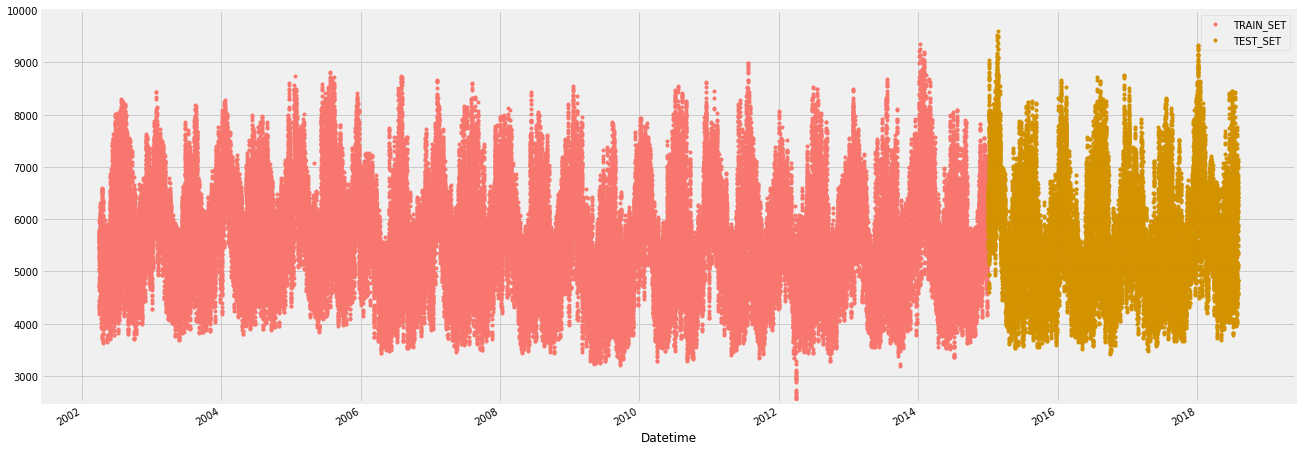

In [ ]:
pjmw_train.rename(columns={'PJMW_MW':'TRAIN_SET'}).join(pjmw_test.rename(columns={'PJMW_MW':'TEST_SET'}), how='outer').plot(figsize=(20,8), style='.', color=palette, grid=True, ylim=(2500,10000))
plt.show()

# Create Features

We must give attention that datetime must follow pandas.DatatimeIndex._ so must change df.index into pandas form example df['date'] as part of column in DataFrame pandas.

In [ ]:
def add_features(df, label=None) :
  df['date'] = df.index
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.isocalendar().week
  df['quarter'] = df['date'].dt.quarter
  df['dayofweek'] =df['date'].dt.dayofweek
  df['hour'] = df['date'].dt.hour
  df['dayofyear'] = df['date'].dt.dayofyear
  df = df.reset_index()
  df = df[['year', 'month', 'day', 'weekofyear', 'quarter', 'dayofweek', 'hour','dayofyear', label]]
  return df

def create_features(df, label=None) :
  df['date'] = df.index
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['day'] = df['date'].dt.day
  df['weekofyear'] = df['date'].dt.isocalendar().week
  df['quarter'] = df['date'].dt.quarter
  df['dayofweek'] =df['date'].dt.dayofweek
  df['hour'] = df['date'].dt.hour
  df['dayofyear'] = df['date'].dt.dayofyear
  X = df[['year', 'month', 'day', 'weekofyear', 'quarter', 'dayofweek', 'hour', 'dayofyear']]
  if label != None:
    y=df[label]
    return X,y
  else:
    return X
  

In [ ]:
#For EDA
train_eda = add_features(pjmw_train, 'PJMW_MW')

#For Training and Testing Model
X_train, y_train = create_features(pjmw_train, "PJMW_MW")
X_test, y_test = create_features(pjmw_test, "PJMW_MW")

In [ ]:
train_eda.head()

,year,month,day,weekofyear,quarter,dayofweek,hour,dayofyear,PJMW_MW
0,2002,12,31,1,4,1,1,365,5077.0
1,2002,12,31,1,4,1,2,365,4939.0
2,2002,12,31,1,4,1,3,365,4885.0
3,2002,12,31,1,4,1,4,365,4857.0
4,2002,12,31,1,4,1,5,365,4930.0


# Exploration Data Analysis in Data Train

Find insight based on week of year

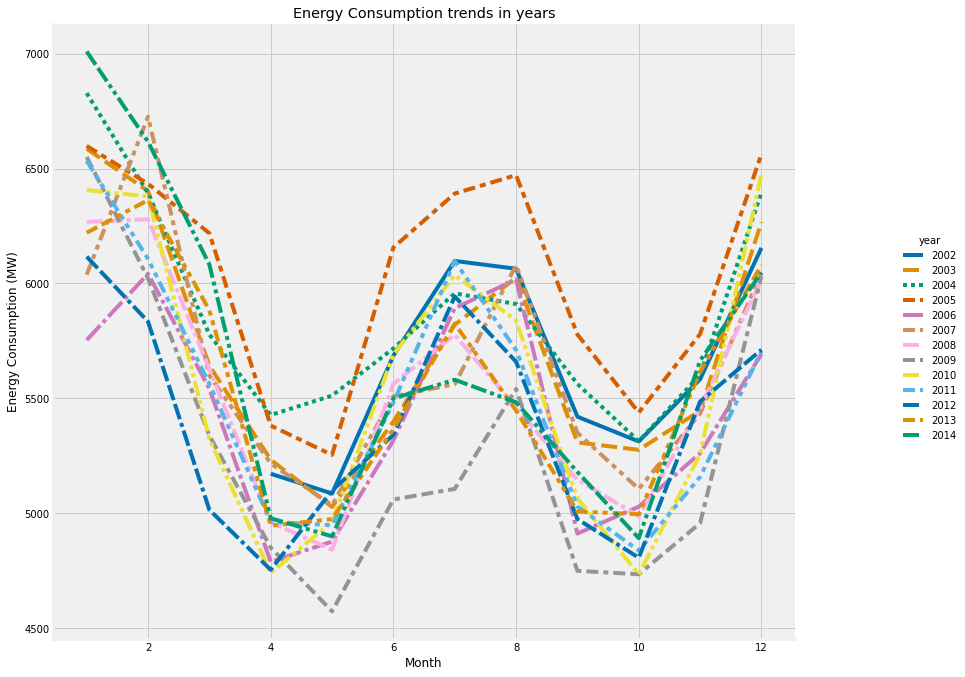

In [ ]:
month = train_eda.groupby(['year', 'month']).agg({'PJMW_MW':'mean'}).reset_index().pivot("month", "year", "PJMW_MW")
sns.relplot(data=month, kind='line', palette='colorblind').set_axis_labels("Month", "Energy Consumption (MW)").fig.set_size_inches(15,10)
plt.title("Energy Consumption trends in years")
plt.show()

In [ ]:
#Highest energy consumption
train_eda.groupby(['dayofyear']).agg({'PJMW_MW':'mean'}).sort_values('PJMW_MW', ascending=False)[:10]

,PJMW_MW
dayofyear,
22,6848.027778
24,6821.576389
23,6804.572917
21,6770.468750
25,6752.763889
26,6684.541667
28,6625.402778
27,6594.322917
17,6584.718750


In [ ]:
#Lowest energy consumption
train_eda.groupby(['month', 'dayofyear']).agg({'PJMW_MW':'mean'}).sort_values('PJMW_MW', ascending=True)[:10]

PJMW_MW
month dayofyear             
9     272        4822.262821
4     111        4832.576923
5     121        4837.166667
4     110        4838.137821
10    285        4841.913462
5     138        4846.721154
10    284        4850.028846
      274        4865.525000
4     118        4866.413462
5     124        4866.621795

Energy consumption each year nearly has same trend. January has highest energy consumption. 2005 was the year with highest average energy consumption, if we look this year many located in the top.

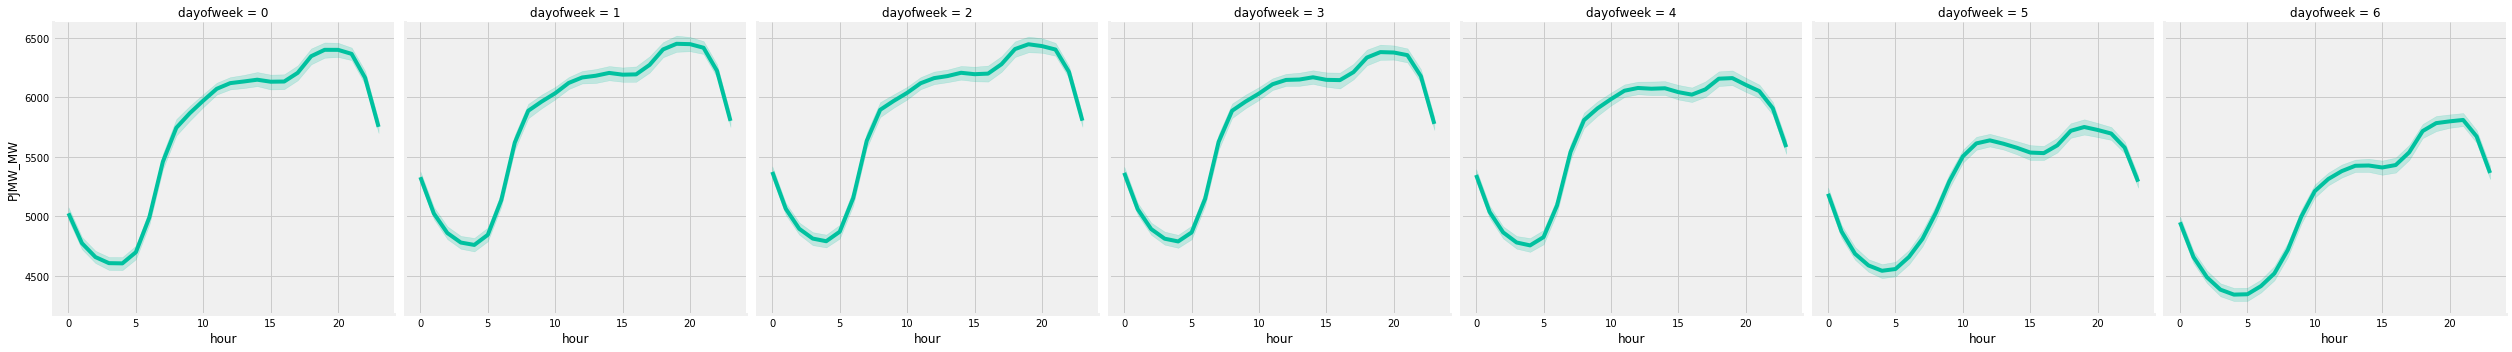

In [ ]:
sns.relplot(data=train_eda, color=palette[3], kind='line', x = 'hour', y='PJMW_MW', col='dayofweek')

Energy has highest consumption in 18-21 PM that people at home after work. If we look at holiday, the energy was the lowest consumption, probably because most of the energy is used from the factory during the working day.

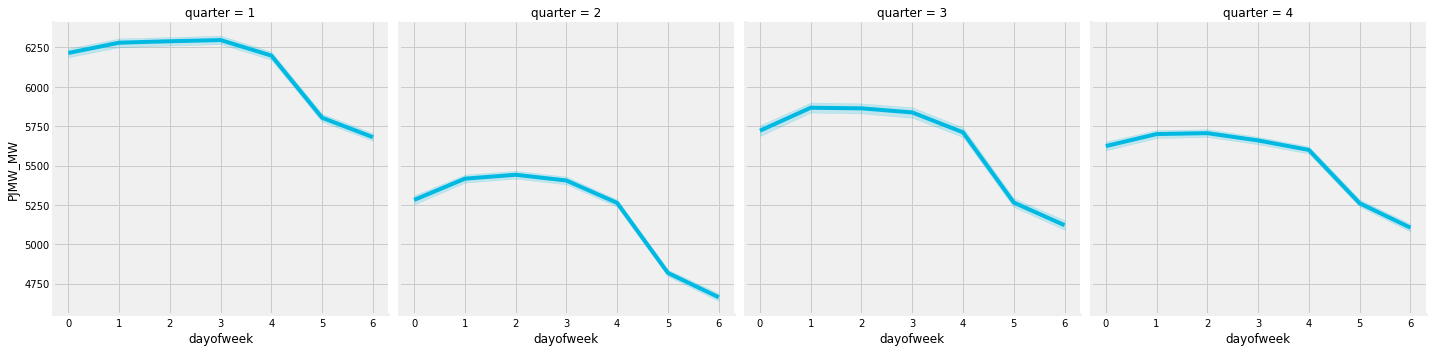

In [ ]:
sns.relplot(data=train_eda, color=palette[4], kind='line', x = 'dayofweek', y='PJMW_MW', col='quarter')

Energy has highest consumption when first quarter and lowest consumption when second quarter. From this insight, we can prepare fuel as needed.

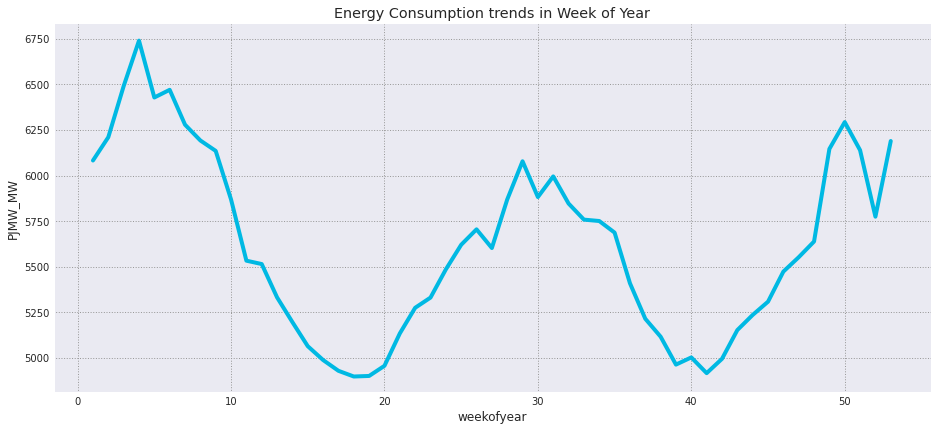

In [ ]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.relplot(data=train_eda.groupby(['weekofyear']).agg({'PJMW_MW':'mean'}), color=palette[4], x = 'weekofyear', y='PJMW_MW', kind='line').fig.set_size_inches(15,6)
plt.title('Energy Consumption trends in Week of Year')
plt.show()

Week 4 was the highest energy consumption.

**Correlation Analysis**

In [ ]:
cor = train_eda.corr()

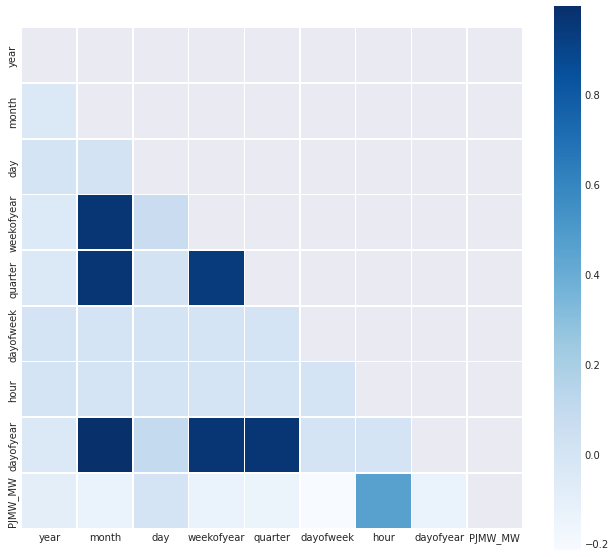

In [ ]:
#Generate mask to upper triangle
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(cor, mask=mask, square=True, linewidths=.6, cmap='Blues', ax=ax)

PJMW_MW has highest correlation with hour feature.

# XGBOOST

## Create Model XGBoost

In [ ]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111766 entries, 2002-12-31 01:00:00 to 2014-01-02 00:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   year        111766 non-null  int64 
 1   month       111766 non-null  int64 
 2   day         111766 non-null  int64 
 3   weekofyear  111766 non-null  UInt32
 4   quarter     111766 non-null  int64 
 5   dayofweek   111766 non-null  int64 
 6   hour        111766 non-null  int64 
 7   dayofyear   111766 non-null  int64 
dtypes: UInt32(1), int64(7)
memory usage: 7.4 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31439 entries, 2015-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        31439 non-null  int64 
 1   month       31439 non-null  int64 
 2   day         31439 non-null  int64 
 3   weekofyear  31439 non-null  UInt32
 4   quarter  

there are UInt32, that will disturb when making model and for decrease file size.

In [ ]:
X_train = X_train.astype('int32')
X_test = X_test.astype('int32')

In [ ]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111766 entries, 2002-12-31 01:00:00 to 2014-01-02 00:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   year        111766 non-null  int32
 1   month       111766 non-null  int32
 2   day         111766 non-null  int32
 3   weekofyear  111766 non-null  int32
 4   quarter     111766 non-null  int32
 5   dayofweek   111766 non-null  int32
 6   hour        111766 non-null  int32
 7   dayofyear   111766 non-null  int32
dtypes: int32(8)
memory usage: 4.3 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31439 entries, 2015-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        31439 non-null  int32
 1   month       31439 non-null  int32
 2   day         31439 non-null  int32
 3   weekofyear  31439 non-null  int32
 4   quarter     31439 non-null  int32
 5

BASE LEARNER

In [ ]:
reg = xgb.XGBRegressor(seed=42, n_estimators=500)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=100, verbose=2)

[05:32:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5122.61	validation_1-rmse:5145.36
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[2]	validation_0-rmse:4169.77	validation_1-rmse:4191.3
[4]	validation_0-rmse:3401.98	validation_1-rmse:3420.41
[6]	validation_0-rmse:2784.97	validation_1-rmse:2808.49
[8]	validation_0-rmse:2288.16	validation_1-rmse:2318.01
[10]	validation_0-rmse:1893.53	validation_1-rmse:1936.52
[12]	validation_0-rmse:1576.43	validation_1-rmse:1623.75
[14]	validation_0-rmse:1326.95	validation_1-rmse:1383.9
[16]	validation_0-rmse:1134	validation_1-rmse:1197.37
[18]	validation_0-rmse:985.489	validation_1-rmse:1062.47
[20]	validation_0-rmse:873.05	validation_1-rmse:957.5
[22]	validation_0-rmse:788.872	validation_1-rmse:880.17
[24]	validation_0-rmse:721.723	validation_1

XGBRegressor(n_estimators=500, seed=42)

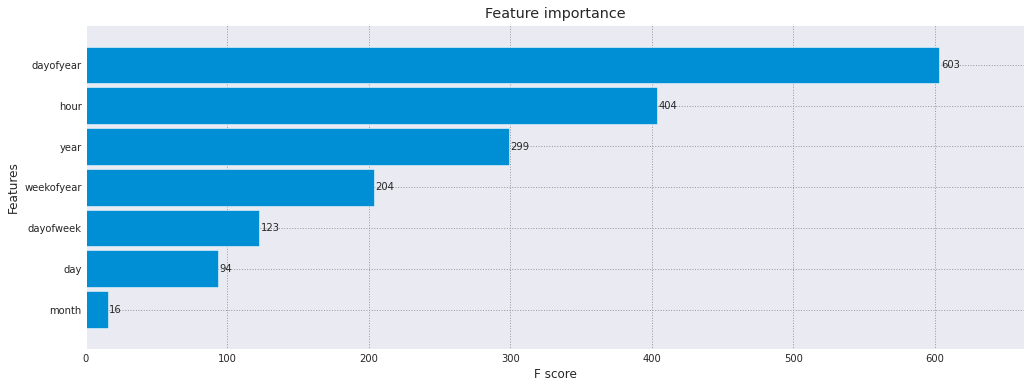

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
plot_importance(reg, height=.9, ax=ax)

Based on XGBOOST, the best importance is weekofyear followed by hour in number two.

## Forecast on test

In [ ]:
pjmw_test['MW_Predict'] = reg.predict(X_test)
pjmw_all = pd.concat([pjmw_train, pjmw_test], sort=False)

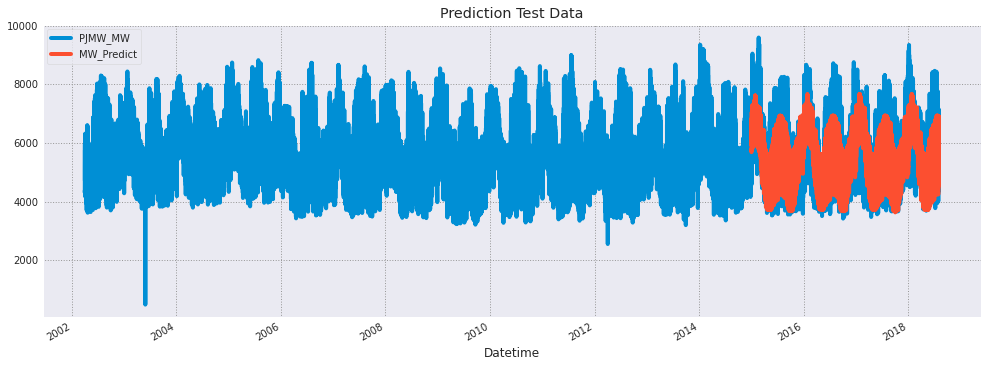

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
pjmw_all[['PJMW_MW','MW_Predict',]].plot(title='Prediction Test Data', ax=ax)
plt.show()

## Error Analysis Base 

In [ ]:
print("RMSE:", np.sqrt(mean_squared_error(pjmw_test['PJMW_MW'], pjmw_test['MW_Predict'])))

RMSE: 658.9672806947964


In [ ]:
print("MAE:", mean_absolute_error(pjmw_test['PJMW_MW'], pjmw_test['MW_Predict']))

MAE: 499.2613107333099


In [ ]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true-y_pred)/y_true)*100
print("MAPE:", str(round(MAPE(pjmw_test['PJMW_MW'], pjmw_test['MW_Predict']),2))+"%")

MAPE: 8.75%


## Hyperparameter Tuning

In [ ]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

params = {'max_depth': np.arange(2, 8, 1),
          'learning_rate': np.arange(0.01, 0.2, 0.05),
          'subsample': np.arange (0.2, 0.8, 0.1),
          'colsample_bytree': np.arange (0.2, 0.8, 0.1),
          'n_estimators': np.arange(60, 300, 30),
          'reg_alpha' : np.arange(0.6, 0.9, 0.05)}

model = xgb.XGBRegressor(random_state=60)
clf = RandomizedSearchCV(estimator=model, param_distributions=params, cv=3, n_iter=20, verbose=2, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[06:42:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.4000000000000001, learning_rate=0.16000000000000003, max_depth=7, n_estimators=270, reg_alpha=0.8500000000000002, subsample=0.4000000000000001; total time=  14.0s
[06:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.4000000000000001, learning_rate=0.16000000000000003, max_depth=7, n_estimators=270, reg_alpha=0.8500000000000002, subsample=0.4000000000000001; total time=  13.9s
[06:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END colsample_bytree=0.4000000000000001, learning_rate=0.16000000000000003, max_depth=7, n_estimators=270, reg_alpha=0.8500000000000002, subsample=0.4000000000000001; tota

RandomizedSearchCV(cv=3, estimator=XGBRegressor(random_state=60), n_iter=20,
                   param_distributions={'colsample_bytree': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': array([0.01, 0.06, 0.11, 0.16]),
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'n_estimators': array([ 60,  90, 120, 150, 180, 210, 240, 270]),
                                        'reg_alpha': array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]),
                                        'subsample': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])},
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
cv_results = clf.cv_results_
RMSE = []
Params = []
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    RMSE.append(np.sqrt(-mean_score))
    Params.append(params)
data = {'RMSE':RMSE, 'Parameter':Params}
res = pd.DataFrame(data=data)
res.sort_values('RMSE', ascending=True)

,RMSE,Parameter
9,566.479070,"{'subsample': 0.2, 'reg_alpha': 0.65, 'n_estim..."
12,567.775942,"{'subsample': 0.6000000000000001, 'reg_alpha':..."
1,572.970072,"{'subsample': 0.30000000000000004, 'reg_alpha'..."
16,576.187136,"{'subsample': 0.2, 'reg_alpha': 0.6, 'n_estima..."
7,577.406369,"{'subsample': 0.7000000000000002, 'reg_alpha':..."
13,579.708941,"{'subsample': 0.2, 'reg_alpha': 0.850000000000..."
18,580.574998,"{'subsample': 0.6000000000000001, 'reg_alpha':..."
6,581.534901,"{'subsample': 0.30000000000000004, 'reg_alpha'..."
2,583.325231,"{'subsample': 0.8000000000000003, 'reg_alpha':..."
0,591.701308,"{'subsample': 0.4000000000000001, 'reg_alpha':..."


Randomized using sr_Float dan sr_int

RMSE : 535.2722242397433	--> 652
{'colsample_bytree': 0.6339586971960278, 'learning_rate': 0.11054252571345119, 'max_depth': 4, 'n_estimators': 180, 'subsample': 0.9085598707858011}

Randomized 2 --> 656

533.5531895283353	{'subsample': 0.5, 'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7}

In [ ]:
reg = xgb.XGBRegressor(random_state=42, colsample_bytree= 0.6339586971960278, learning_rate= 0.11054252571345119, max_depth= 4, n_estimators= 180, subsample= 0.9085598707858011)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=100, verbose=2)

[03:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5063.46	validation_1-rmse:5077.8
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[2]	validation_0-rmse:4030.07	validation_1-rmse:4045.86
[4]	validation_0-rmse:3213.03	validation_1-rmse:3222.55
[6]	validation_0-rmse:2570.73	validation_1-rmse:2576.91
[8]	validation_0-rmse:2068.32	validation_1-rmse:2082.53
[10]	validation_0-rmse:1675.21	validation_1-rmse:1700.1
[12]	validation_0-rmse:1371.28	validation_1-rmse:1407.73
[14]	validation_0-rmse:1138.75	validation_1-rmse:1185.85
[16]	validation_0-rmse:964.122	validation_1-rmse:1024.81
[18]	validation_0-rmse:833.093	validation_1-rmse:911.871
[20]	validation_0-rmse:735.414	validation_1-rmse:827.155
[22]	validation_0-rmse:666.302	validation_1-rmse:772.721
[24]	validation_0-rmse:613.883	valid

XGBRegressor(colsample_bytree=0.6339586971960278,
             learning_rate=0.11054252571345119, max_depth=4, n_estimators=180,
             random_state=42, subsample=0.9085598707858011)

In [ ]:
pjmw_test['MW_Predict'] = reg.predict(X_test)
pjmw_all = pd.concat([pjmw_train, pjmw_test], sort=False)

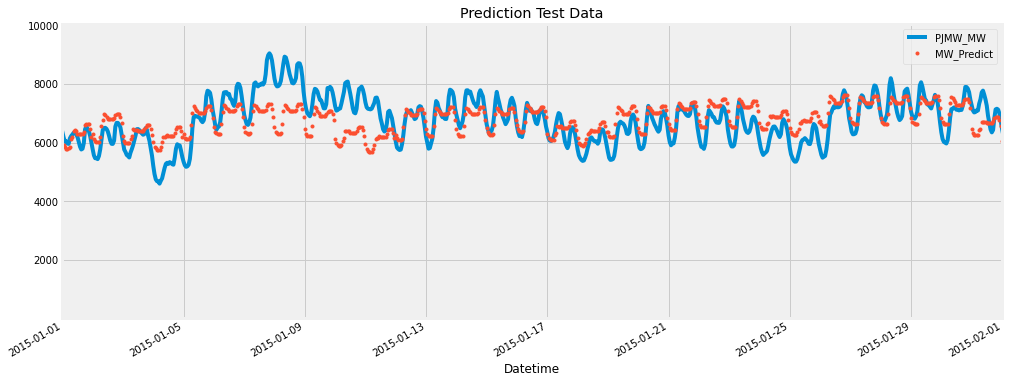

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
pjmw_all[['PJMW_MW','MW_Predict']].plot(title='Prediction Test Data', ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
plt.show()

## Error Analysis After Tuning

In [ ]:
print("RMSE:", np.sqrt(mean_squared_error(pjmw_test['PJMW_MW'], pjmw_test['MW_Predict'])))

RMSE: 652.2489058774934


In [ ]:
print("MAE:", mean_absolute_error(pjmw_test['PJMW_MW'], pjmw_test['MW_Predict']))

MAE: 493.4540106669239


In [ ]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true-y_pred)/y_true)*100
print("MAPE:", str(round(MAPE(pjmw_test['PJMW_MW'], pjmw_test['MW_Predict']),2))+"%")

MAPE: 8.63%


In [ ]:
pjmw_test['abs_error']=(pjmw_test['PJMW_MW']-pjmw_test['MW_Predict']).apply(np.abs)
error_by_day = pjmw_test.groupby(['year','month', 'day']).mean()[['MW_Predict', 'PJMW_MW', 'abs_error']]
error_by_day.sort_values('abs_error')

MW_Predict      PJMW_MW    abs_error
year month day                                       
2017 5     21   4513.967285  4546.458333    63.735036
2015 4     9    5298.129883  5309.166667    71.591797
2017 5     6    4590.619629  4510.208333    82.102732
2015 11    30   5627.540527  5590.458333    94.827128
2016 10    22   4694.257812  4616.875000    98.631348
...                     ...          ...          ...
2015 2     16   6683.358887  8665.625000  1982.266215
           15   6131.300781  8202.833333  2071.532694
           20   6595.020020  8693.875000  2098.854980
2017 12    31   5364.355469  7500.125000  2135.769368
2018 1     6    6324.317871  8579.375000  2255.057048

[1311 rows x 3 columns]

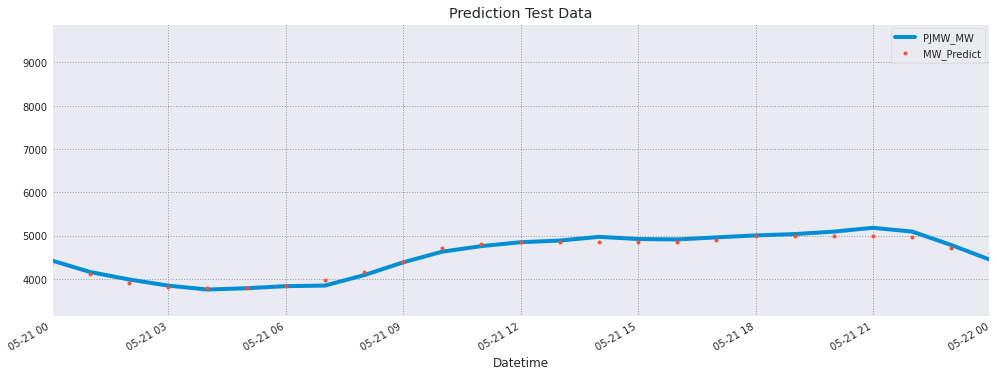

In [ ]:
#Best Error
fig,ax = plt.subplots(figsize=(15,6))
pjmw_test[['PJMW_MW','MW_Predict']].plot(title='Prediction Test Data', ax=ax, style=['-','.'])
ax.set_xbound(lower='05-21-2017', upper='05-22-2017')
plt.show()

# Prophet

In [ ]:
pjmw_pro = pd.read_csv('/content/drive/MyDrive/Data Scientist/XGBoost/PJMW_hourly.csv.zip (Unzipped Files)/PJMW_hourly.csv', parse_dates=True, index_col='Datetime', low_memory=False)
pjmw_pro.sort_values('Datetime',ascending=True)

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [ ]:
pjmw_pro_train=pjmw_pro[pjmw_pro.index<='2015-01-01'].copy()
pjmw_pro_test=pjmw_pro[pjmw_pro.index>'2015-01-01'].copy()

In Prophet, we must change name dataframe into ds as datetime and y as target.

In [ ]:
pjmw_pro_train = pjmw_pro_train.reset_index().rename(columns={'Datetime':'ds', 'PJMW_MW':'y'})
pjmw_pro_test = pjmw_pro_test.reset_index().rename(columns={'Datetime':'ds'})

In [ ]:
pjmw_pro_test.head()

,ds,PJMW_MW
0,2015-12-31 01:00:00,4530.0
1,2015-12-31 02:00:00,4383.0
2,2015-12-31 03:00:00,4299.0
3,2015-12-31 04:00:00,4338.0
4,2015-12-31 05:00:00,4427.0


## Create Model Prophet

In [ ]:
model = Prophet(interval_width=.95)
model.fit(pjmw_pro_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
forecast = model.predict(pjmw_pro_test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,5645.641916,4520.055739,6630.441959,5645.641916,5645.641916,-98.893072,-98.893072,-98.893072,-636.413638,-636.413638,-636.413638,224.257956,224.257956,224.257956,313.262609,313.262609,313.262609,0.0,0.0,0.0,5546.748844
1,2015-01-01 02:00:00,5645.648111,4271.658769,6383.567127,5645.648111,5645.648111,-312.432800,-312.432800,-312.432800,-849.262667,-849.262667,-849.262667,223.229884,223.229884,223.229884,313.599984,313.599984,313.599984,0.0,0.0,0.0,5333.215311
2,2015-01-01 03:00:00,5645.654305,4148.107401,6300.135878,5645.654305,5645.654305,-423.628899,-423.628899,-423.628899,-959.496652,-959.496652,-959.496652,221.919644,221.919644,221.919644,313.948109,313.948109,313.948109,0.0,0.0,0.0,5222.025406
3,2015-01-01 04:00:00,5645.660500,4142.881332,6326.325761,5645.660500,5645.660500,-423.134112,-423.134112,-423.134112,-957.781704,-957.781704,-957.781704,220.340605,220.340605,220.340605,314.306987,314.306987,314.306987,0.0,0.0,0.0,5222.526388
4,2015-01-01 05:00:00,5645.666694,4275.089320,6415.095731,5645.666694,5645.666694,-305.375375,-305.375375,-305.375375,-838.560975,-838.560975,-838.560975,218.508981,218.508981,218.508981,314.676619,314.676619,314.676619,0.0,0.0,0.0,5340.291319


In [ ]:
test = pd.merge(pjmw_pro_test, forecast, how='inner')[['ds','PJMW_MW', 'yhat_lower', 'yhat', 'yhat_upper']].set_index('ds')
test['abs_error']= (test['PJMW_MW']-test['yhat']).apply(np.abs)
test.sort_values('abs_error', ascending=True)

,PJMW_MW,yhat_lower,yhat,yhat_upper,abs_error
ds,,,,,
2017-09-18 00:00:00,4743.0,-1130.446469,4742.998428,10402.678163,0.001572
2015-09-28 23:00:00,5316.0,3915.008185,5316.053089,6551.067097,0.053089
2015-11-21 10:00:00,5518.0,3947.157160,5517.896228,6929.982203,0.103772
2017-05-18 09:00:00,5490.0,466.484385,5490.108420,10328.957481,0.108420
2016-05-22 02:00:00,3733.0,1295.386484,3733.178005,5863.092948,0.178005
...,...,...,...,...,...
2018-01-07 02:00:00,8173.0,-2090.048584,4897.678279,11438.176907,3275.321721
2018-01-07 05:00:00,8295.0,-1669.723390,4910.887102,11502.709155,3384.112898
2015-02-20 07:00:00,9512.0,5113.426542,6119.774716,7127.315095,3392.225284


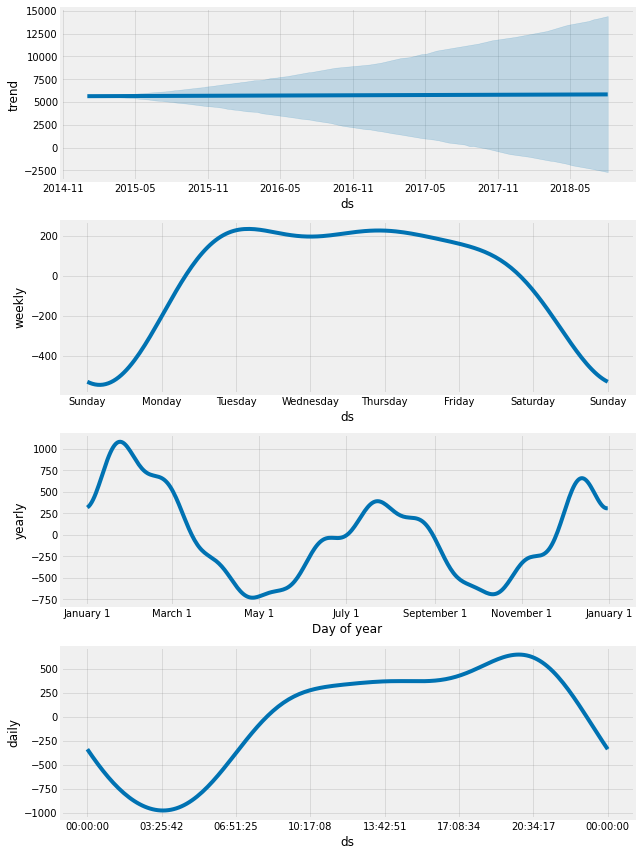

In [ ]:
model.plot_components(forecast)
plt.show()

This is trend that we have discussed in Exploration Data Analysis.

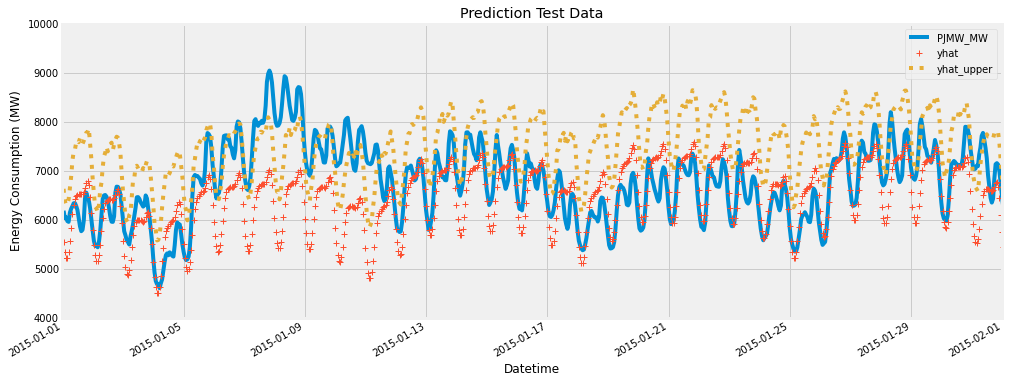

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
test[['PJMW_MW','yhat', 'yhat_upper']].plot(title='Prediction Test Data', ax=ax, style=['-','+', ':'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(4000, 10000)
ax.set_xlabel('Datetime')
ax.set_ylabel('Energy Consumption (MW)')
plt.show()

Error Analysis

In [ ]:
print("RMSE:", np.sqrt(mean_squared_error(test['PJMW_MW'], test['yhat'])))

RMSE: 724.5769480286281


In [ ]:
print("MAE:", mean_absolute_error(test['PJMW_MW'], test['yhat']))

MAE: 574.2189458582898


In [ ]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true-y_pred)/y_true)*100
print("MAPE:", str(round(MAPE(test['PJMW_MW'], test['yhat']),2))+"%")

MAPE: 10.28%


This MAPE is worse than use XGBOOST

## Adding Holidays

We will use holidays, we wish will improve performance that Prophet comes with Holidays effect

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as cal

cal = cal()

In [ ]:
pjmw_pro['date'] = pjmw_pro.index
pjmw_pro['is_holiday'] = pjmw_pro.date.isin([d.date() for d in cal.holidays()])
df_hol = pjmw_pro[pjmw_pro['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})
df_hol['holiday'] = 'USFederalHoliday'
df_hol = df_hol.drop(['PJMW_MW', 'date', 'is_holiday'], axis=1)
df_hol.head()

,ds,holiday
0,2003-01-01,USFederalHoliday
1,2002-12-25,USFederalHoliday
2,2002-11-28,USFederalHoliday
3,2002-11-11,USFederalHoliday
4,2002-10-14,USFederalHoliday


In [ ]:
model_holidays = Prophet(holidays=df_hol, yearly_seasonality=True)
model_holidays.fit(pjmw_pro_train)

In [ ]:
forecast_holidays=model_holidays.predict(pjmw_pro_test)

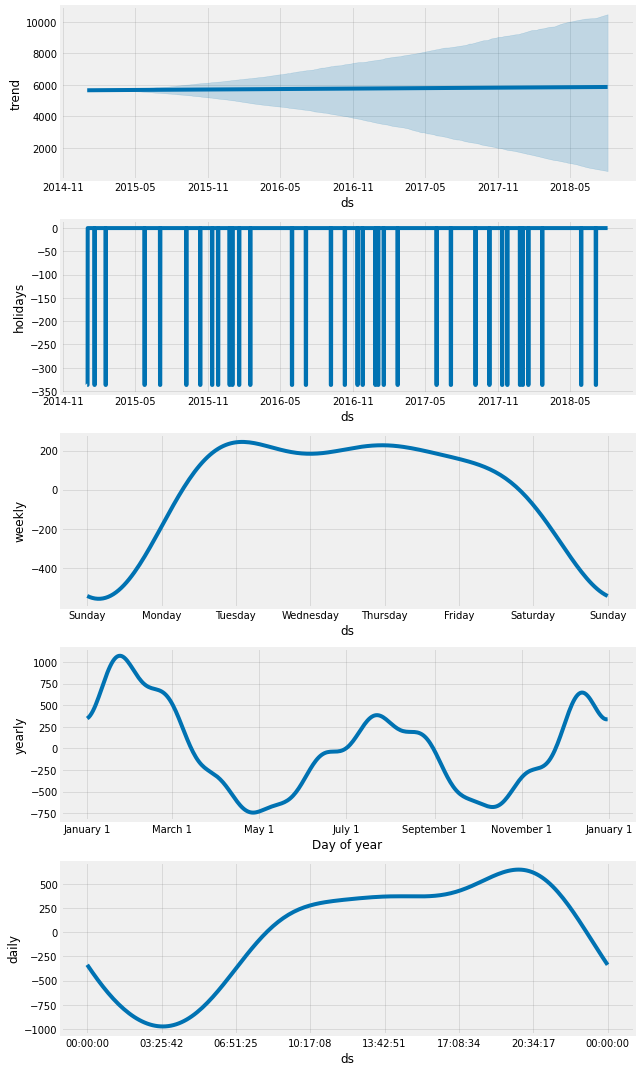

In [ ]:
model_holidays.plot_components(forecast_holidays)
plt.show()

In [ ]:
test_holidays = pd.merge(pjmw_pro_test, forecast_holidays, how='inner')[['ds','PJMW_MW', 'yhat_lower', 'yhat', 'yhat_upper']].set_index('ds')

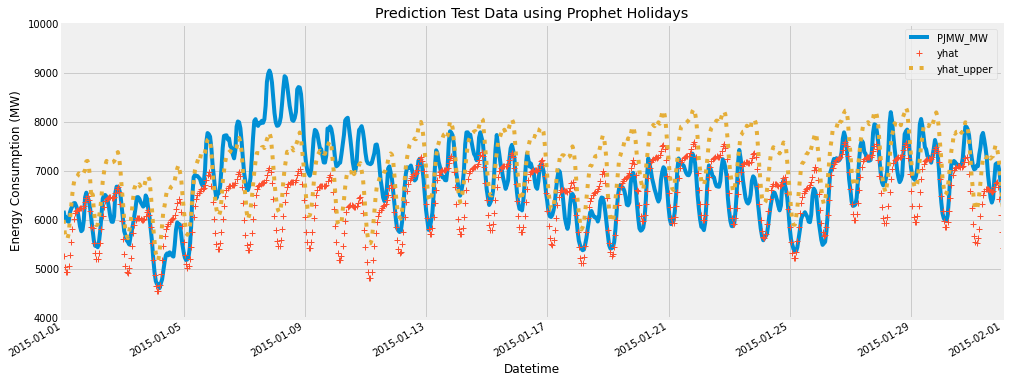

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
test_holidays[['PJMW_MW','yhat', 'yhat_upper']].plot(title='Prediction Test Data using Prophet Holidays', ax=ax, style=['-','+', ':'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(4000, 10000)
ax.set_xlabel('Datetime')
ax.set_ylabel('Energy Consumption (MW)')
plt.show()

Error Analysis

In [ ]:
print("RMSE:", np.sqrt(mean_squared_error(test_holidays['PJMW_MW'], test_holidays['yhat'])))

RMSE: 726.5379566722537


In [ ]:
print("MAE:", mean_absolute_error(test_holidays['PJMW_MW'], test_holidays['yhat']))

MAE: 577.6624042632443


In [ ]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true-y_pred)/y_true)*100
print("MAPE:", str(round(MAPE(test_holidays['PJMW_MW'], test_holidays['yhat']),2))+"%")

MAPE: 10.36%


Holidays dont affect the energy consumption in West Region. This is proved by number of MAPE increase. It is also seen that energy consumption increases during office hours.